In [1]:
%cd /content
!rm -r darknet/ # supprimer darknet s'il existe
!git clone https://github.com/AlexeyAB/darknet.git # telecharger darknet depuis github
%cd darknet # acceder au dossier 
import re
# changer les params a 1 depuis le fichier Makefile
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile 
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
# !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make
!chmod +x ./darknet # allows permission 

/content
rm: cannot remove 'darknet/': No such file or directory
Cloning into 'darknet'...
remote: Enumerating objects: 14978, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 14978 (delta 9), reused 22 (delta 7), pack-reused 14949
Receiving objects: 100% (14978/14978), 13.40 MiB | 24.55 MiB/s, done.
Resolving deltas: 100% (10172/10172), done.
/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: varia

In [4]:
# difinir la fonction imShow
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
# importer le data qui contient les images et les labels...
repo_url = 'https://github.com/WalidKhelifa/Mask-detection-Yolo-Tiny-v3/tree/main/data/yolotinyv3_medmask_demo'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
%rm -r {repo_dir_path}
!git clone {repo_url}
%cd {repo_dir_path}

/content
rm: cannot remove '/content/yolotinyv3_medmask_demo': No such file or directory
Cloning into 'yolotinyv3_medmask_demo'...
remote: Enumerating objects: 1733, done.
remote: Total 1733 (delta 0), reused 0 (delta 0), pack-reused 1733
Receiving objects: 100% (1733/1733), 208.88 MiB | 41.00 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Checking out files: 100% (1537/1537), done.
/content/yolotinyv3_medmask_demo


In [6]:
from google.colab import drive
drive.mount('/content/drive')
# pour utiliser votre propre dataset , remplacer false by true et ajouter votre data
## REMOVE THIS TO USE YOUR OWN IMAGES
if (False):
  #remove the obj folder
  !rm -rf /content/yolotinyv3_medmask_demo/obj
  #copy images to obj folder
  #this can take a few minutes depending on dataset size. 
  !cp -rf '/content/drive/My Drive/datasets/medmask_yolo/obj' '/content/yolotinyv3_medmask_demo/obj'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Change the labels in obj.names to our current labels
labels_path = '/content/yolotinyv3_medmask_demo/obj.names'
#make a list of your labels
labels = ['mask','no mask']

with open(labels_path, 'w') as f:

    f.write('\n'.join(labels))

#check that the labels file is correct
!cat /content/yolotinyv3_medmask_demo/obj.names

mask
no mask

In [8]:
# Change the number of classes in obj.data.
import re
objdata = '/content/yolotinyv3_medmask_demo/obj.data'
with open(objdata) as f:
    s = f.read()

#the number of classes is equal to the number of labels
num_classes = len(labels)   
s = re.sub('classes = \d*','classes = ' + str(num_classes),s) # remplacer classes = \d* par classes= 2

with open(objdata, 'w') as f:
  f.write(s)
!cat /content/yolotinyv3_medmask_demo/obj.data

classes= 2
train  = /content/yolotinyv3_medmask_demo/train.txt
valid  = /content/yolotinyv3_medmask_demo/valid.txt
names = /content/yolotinyv3_medmask_demo/obj.names
backup = backup/

In [9]:
%cd ../yolotinyv3_medmask_demo/

/content/yolotinyv3_medmask_demo


In [10]:
#in this case we use 85 percent of the images for training
#10 percent for validation, 5 for testing.
#as the dataset is small, one can use 90 percent for training and split the rest
#for validation/testing as desired.
#double clicking on the train or test text files will open the file in a new
#tab in colab and display the content.
!python3 folder2textYolo.py 85 10 /content/yolotinyv3_medmask_demo/obj # we use a script that splits the images


Your image file extension is: .jpg
Number of images: 762
Number of images used for training 648
Number of images used for validation 76
Number of images used for testing 38


In [11]:
!head -n 24 /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg #afficher les 24 premiers lignes du fichier cfg

[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 4000
policy=steps
steps=3200,3600
scales=.1,.1



In [12]:
# set the number of max_batches - min 2000 per class:
max_batch=4000
# calculate the 2 steps values:
step1 = 0.8 * max_batch
step2 = 0.9 * max_batch

# we also need to adjust the number of classes and a parameter called filter size 
# that are both is inside the model structure

# num_classes = len(labels)
num_filters = (num_classes + 5) * 3


cfg_file = '/content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg'

with open(cfg_file) as f:
    s = f.read()
# (re.sub('[a-z]*@', 'ABC@', s))
s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)
# pad=1\nfilters=\d\d
# s = re.sub('CUDNN=0','CUDNN=1',s)
# s = re.sub('OPENCV=0','OPENCV=1',s)

with open(cfg_file, 'w') as f:
  # s = re.sub('GPU=0','GPU=1',s)
  f.write(s)

In [12]:
!head -n 24 /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg #reafficher les 24 premiers lignes du fichier cfg after update


[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 4000
policy=steps
steps=3200,3600
scales=.1,.1



In [13]:
!tail -n 64 /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg #afficher les 64 premiers lignes du fichier cfg


stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=21
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=2
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 8

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=21
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=2
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1


In [14]:
%cd /content/darknet/ # acceder au dossier darknet pour lancer le train

/content/darknet


In [15]:
!./darknet detector train /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg /content/yolotinyv3_medmask_demo/yolov3-tiny.conv.15 -dont_show -ext_output -map

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.754081), count: 4, class_loss = 0.709356, iou_loss = 0.242378, total_loss = 0.951734 
 total_bbox = 986845, rewritten_bbox = 0.031616 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.757596), count: 3, class_loss = 0.033791, iou_loss = 0.105286, total_loss = 0.139077 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.817845), count: 13, class_loss = 0.583700, iou_loss = 0.363736, total_loss = 0.947436 
 total_bbox = 986861, rewritten_bbox = 0.031615 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.833555), count: 6, class_loss = 0.594494, iou_loss = 0.181799, total_loss = 0.776293 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.824360), count: 3, class_loss = 0.354968, iou_loss = 0.126317, to

In [ ]:
# verifier la performance du model

In [16]:
!./darknet detector map /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg "/content/darknet/backup/yolov3-tiny_obj_best.weights" -points 0

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256   

In [ ]:
# lancer la detection a partir d'une image de test, on choisi les best weights obtenu depuis le train

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256   

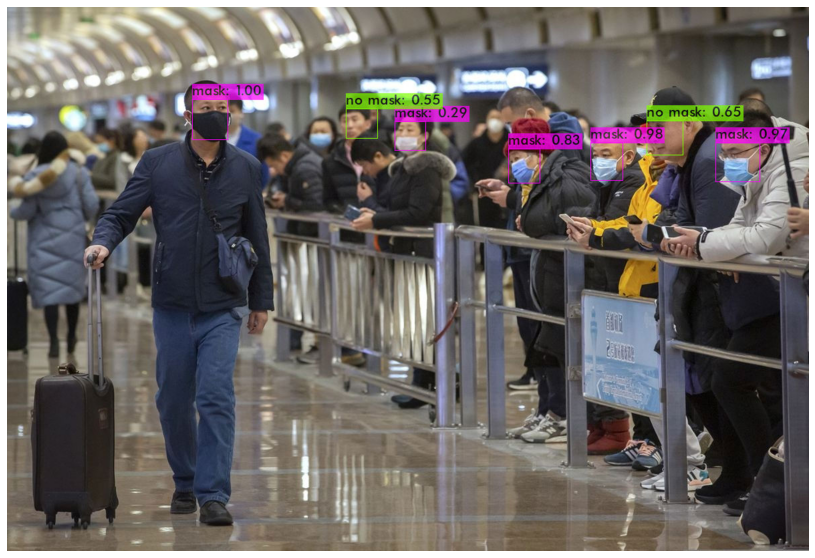

In [17]:
!./darknet detector test /content/yolotinyv3_medmask_demo/obj.data  /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg  "/content/darknet/backup/yolov3-tiny_obj_best.weights" /content/yolotinyv3_medmask_demo/obj/0633.jpg -ext_output
imShow('predictions.jpg') # sauvegarde de l'image after use detection

In [18]:
# sauvegarder les nouveaux poids obtenu dans le drive
!cp /content/darknet/backup/yolov3-tiny_obj_1000.weights  '/content/drive/My Drive/'
!cp /content/darknet/backup/yolov3-tiny_obj_2000.weights  '/content/drive/My Drive/'
!cp /content/darknet/backup/yolov3-tiny_obj_3000.weights  '/content/drive/My Drive/'
!cp /content/darknet/backup/yolov3-tiny_obj_4000.weights  '/content/drive/My Drive/'
!cp /content/darknet/backup/yolov3-tiny_obj_best.weights  '/content/drive/My Drive/'
!cp /content/darknet/backup/yolov3-tiny_obj_final.weights '/content/drive/My Drive/'
!cp /content/darknet/backup/yolov3-tiny_obj_last.weights '/content/drive/My Drive/'